In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
from matplotlib import pyplot
from scipy.sparse import *
from scipy.stats import loguniform

In [ ]:
urm_path = '/content/data_train.csv'

urm_all_df = pd.read_csv(filepath_or_buffer=urm_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:float},
                                engine='python')

urm_all_df.columns = ["UserID", "ItemID", "Interaction"]

In [ ]:
urm_all_df.head(10)

,UserID,ItemID,Interaction
0,1,7,1.0
1,1,15,1.0
2,1,16,1.0
3,1,133,1.0
4,1,161,1.0
5,1,187,1.0
6,1,205,1.0
7,1,222,1.0
8,1,237,1.0
9,1,354,1.0


In [ ]:
print ("The number of interactions is {}".format(len(urm_all_df)))

The number of interactions is 478730


In [ ]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


# Remove empty profiles

In [ ]:
# Remove empty IDs
mapped_id, original_id = pd.factorize(urm_all_df["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(urm_all_df["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)



# Let's create the mapping from items indices to original item_ids
item_index_to_original_ID = pd.Series(item_original_ID_to_index.index,index = item_original_ID_to_index.values)



original_item_ID = 125
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index[original_item_ID]))


urm_all_df["UserID"] = urm_all_df["UserID"].map(user_original_ID_to_index)
urm_all_df["ItemID"] = urm_all_df["ItemID"].map(item_original_ID_to_index)
urm_all_df.head(n=10)

New index for item 125 is 93


,UserID,ItemID,Interaction
0,0,0,1.0
1,0,1,1.0
2,0,2,1.0
3,0,3,1.0
4,0,4,1.0
5,0,5,1.0
6,0,6,1.0
7,0,7,1.0
8,0,8,1.0
9,0,9,1.0


In [ ]:
userID_unique = urm_all_df["UserID"].unique()
itemID_unique = urm_all_df["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(urm_all_df)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


**See the distributoin of how many users interacted with one item**

<Axes: >

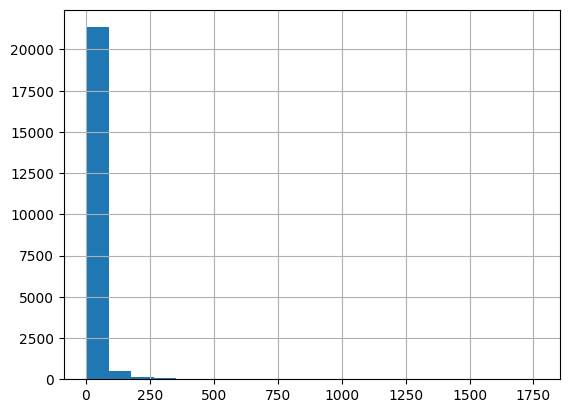

In [ ]:
urm_all_df.groupby(["ItemID"])['UserID'].count().hist(bins=20)

In [ ]:
urm_all = sps.coo_matrix((urm_all_df["Interaction"].values,
                          (urm_all_df["UserID"].values, urm_all_df["ItemID"].values)))

urm_all

<12638x22222 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in COOrdinate format>

In [ ]:
urm_all.tocsr()

<13025x22348 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

# Predictor

Here's the class for our predictor

In [ ]:
!unzip /content/Recommenders.zip

Archive:  /content/Recommenders.zip
   creating: Recommenders/__pycache__/
  inflating: Recommenders/__pycache__/Recommender_utils.cpython-38.pyc  
  inflating: Recommenders/Recommender_utils.py  
   creating: Recommenders/Similarity/
   creating: Recommenders/Similarity/__pycache__/
  inflating: Recommenders/Similarity/__pycache__/Compute_Similarity_Python.cpython-38.pyc  
  inflating: Recommenders/Similarity/Compute_Similarity_Python.py  


In [ ]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
class ItemKNNCFRecommender(object):

    def __init__(self, URM):
        self.URM = URM


    def fit(self, topK=50, shrink=6, normalize=True, similarity="cosine"):

        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink,
                                                  topK=topK, normalize=normalize,
                                                  similarity = similarity)

        self.W_sparse = similarity_object.compute_similarity()


    def recommend(self, user_id, at=None, exclude_seen=True, users_not_in_train=[]):
        # Check if user_id is a valid index
        if user_id < 0 or user_id >= self.URM.shape[0]:
            print(f"Invalid user_id: {user_id}")
            return

        # Check if user_id not in train use the topRec
        if user_id in users_not_in_train:
            return ["517 189 44 0 284 808 285 1 557 1266"]

        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

# Fine-tune the hyperparametrs

In [ ]:
def precision(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)

    return precision_score

def recall(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]

    return recall_score

def AP(recommended_items, relevant_items):

    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)

    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))

    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_algorithm(URM_test, recommender_object, at=10):

    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0

    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]

        if len(relevant_items)>0:

            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)

    mean_precision = cumulative_precision / num_eval
    mean_recall = cumulative_recall / num_eval
    MAP = cumulative_AP / num_eval

    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP))
    return MAP, mean_precision, mean_recall

Split the data into train/val


In [ ]:
train_test_split = 0.80

n_interactions = urm_all.nnz

train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])

urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))

val_mask = np.logical_not(train_mask)

urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))

**Save similarity matrix for the model trained on 5 different folds**

In [ ]:
from scipy.sparse import save_npz, load_npz
import gc

In [ ]:
# Load train fold and train a model on it

for fold_n in range(5):
  print(f"Loading train fold {fold_n}")
  urm_train = load_npz(f"/content/drive/MyDrive/RecSys/5-fold CV /Folds/train_noemptyprofiles_fold{fold_n}.npz")
  IBCF_recommender = ItemKNNCFRecommender(urm_train)
  print(f"Training the model on train fold {fold_n}")
  IBCF_recommender.fit(topK = 14,shrink=7, similarity = 'cosine')
  print(f"Saving similarity matrix of the model trained on train fold {fold_n}")
  item_item_S = IBCF_recommender.W_sparse
  save_npz(f"/content/drive/MyDrive/RecSys/5-fold CV /IBCF/ItItSimilarity_trained_fold{fold_n}_noemptyprofiles_IBCF_kaggleMAP0.11585.npz", item_item_S)

  # Delete the model to empty RAM
  del IBCF_recommender
  gc.collect()

Loading train fold 0
Training the model on train fold 0
Similarity column 22222 (100.0%), 1314.04 column/sec. Elapsed time 16.91 sec
Saving similarity matrix of the model trained on train fold 0
Loading train fold 1
Training the model on train fold 1
Similarity column 22221 (100.0%), 1512.11 column/sec. Elapsed time 14.70 sec
Saving similarity matrix of the model trained on train fold 1
Loading train fold 2
Training the model on train fold 2
Similarity column 22222 (100.0%), 1486.22 column/sec. Elapsed time 14.95 sec
Saving similarity matrix of the model trained on train fold 2
Loading train fold 3
Training the model on train fold 3
Similarity column 22222 (100.0%), 1348.10 column/sec. Elapsed time 16.48 sec
Saving similarity matrix of the model trained on train fold 3
Loading train fold 4
Training the model on train fold 4


# K-fold Cross-Validatoin


Define the k data partitions for k-folds cross-validation

In [ ]:
from sklearn.model_selection import KFold

n_interactions = urm_all.nnz
num_folds = 10

kf = KFold(n_splits=num_folds,  shuffle = True)
data_folds = []
indices = np.arange(n_interactions)
for train_inc, val_inc in kf.split(indices):
  train_mask = np.full(n_interactions,True)
  train_mask[val_inc] = False
  val_mask = np.logical_not(train_mask)

  fold_urm_train = sps.csr_matrix((urm_all.data[train_mask],
                            (urm_all.row[train_mask], urm_all.col[train_mask])))
  fold_urm_val = sps.csr_matrix((urm_all.data[val_mask],
                            (urm_all.row[val_mask], urm_all.col[val_mask])))
  data_folds.append({"train":fold_urm_train,"val":fold_urm_val})


**Implement the iterative random hyperparameter search with k-fold cross-validation**

Number of the most similar neighbours to consider

In [ ]:
rnd_k = set(loguniform.rvs(10, 200, size=11).astype(int))
rnd_shrink = set(loguniform.rvs(1, 80, size=11).astype(int))
print(rnd_k)
print(rnd_shrink)

[147 100  36  14 104  15  37  18 128  80 114]
[ 3 57  8  6  5  9 19  3  7  1 13]


In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "MAP"])
hyperparameter_search_rnd["k"] = rnd_k
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

default_shrink = 10

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = ItemKNNCFRecommender(fold['train'])
      recommender.fit(shrink=default_shrink, topK=hyperparameter_search_rnd.loc[index,"k"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"k"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 22348 (100.0%), 1009.46 column/sec. Elapsed time 22.14 sec
Recommender results are: Precision = 501.3000, Recall = 1208.9436, MAP = 0.0664
Fold 1 evaluations started
Similarity column 22348 (100.0%), 1529.33 column/sec. Elapsed time 14.61 sec
Recommender results are: Precision = 482.6000, Recall = 1186.7020, MAP = 0.0661
Fold 2 evaluations started
Similarity column 22348 (100.0%), 1522.49 column/sec. Elapsed time 14.68 sec
Recommender results are: Precision = 492.8000, Recall = 1208.9557, MAP = 0.0655
Fold 3 evaluations started
Similarity column 22348 (100.0%), 1526.37 column/sec. Elapsed time 14.64 sec
Recommender results are: Precision = 497.4000, Recall = 1201.5073, MAP = 0.0658
Fold 4 evaluations started
Similarity column 22348 (100.0%), 1532.76 column/sec. Elapsed time 14.58 sec
Recommender results are: Precision = 495.0000, Recall = 1177.1701, MAP = 0.0642
Fold 5 evaluations started
Similarity column 22348 (100.0%), 1523.95 column/sec.

      k       MAP
3    14  0.065414
5    15  0.065403
7    18  0.065194
2    36  0.064818
6    37  0.064773
9    80  0.064198
1   100  0.064002
4   104  0.064001
10  114  0.063874
8   128  0.063842
0   147  0.063596


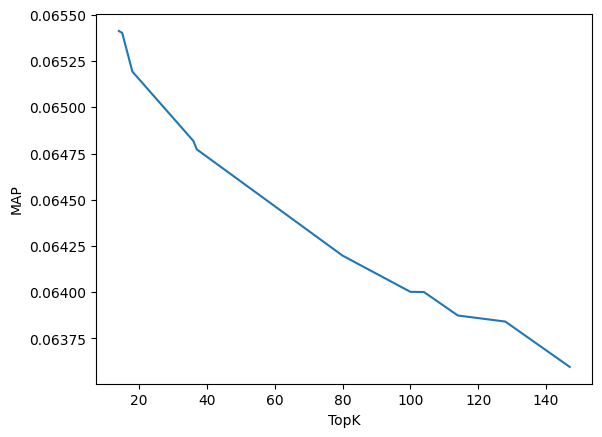

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Shrinkage

In [ ]:
best_k_value = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]

In [ ]:
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = rnd_shrink
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]


for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = ItemKNNCFRecommender(fold['train'])
      recommender.fit(shrink=hyperparameter_search_rnd.loc[index,"shrink"], topK=best_k_value["k"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"shrink"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 22348 (100.0%), 1561.98 column/sec. Elapsed time 14.31 sec
Recommender results are: Precision = 495.8000, Recall = 1197.2452, MAP = 0.0664
Fold 1 evaluations started
Similarity column 22348 (100.0%), 1591.30 column/sec. Elapsed time 14.04 sec
Recommender results are: Precision = 480.4000, Recall = 1168.1900, MAP = 0.0653
Fold 2 evaluations started
Similarity column 22348 (100.0%), 1620.06 column/sec. Elapsed time 13.79 sec
Recommender results are: Precision = 495.4000, Recall = 1220.8911, MAP = 0.0652
Fold 3 evaluations started
Similarity column 22348 (100.0%), 1623.07 column/sec. Elapsed time 13.77 sec
Recommender results are: Precision = 497.0000, Recall = 1189.9079, MAP = 0.0650
Fold 4 evaluations started
Similarity column 22348 (100.0%), 1611.04 column/sec. Elapsed time 13.87 sec
Recommender results are: Precision = 491.4000, Recall = 1164.2789, MAP = 0.0632
Fold 5 evaluations started
Similarity column 22348 (100.0%), 1616.64 column/sec.

     k  shrink       MAP
9   14       1  0.064689
0   14       3  0.065286
7   14       3  0.065286
4   14       5  0.065408
3   14       6  0.065413
8   14       7  0.065484
2   14       8  0.065432
5   14       9  0.065362
10  14      13  0.065013
6   14      19  0.064488
1   14      57  0.061646


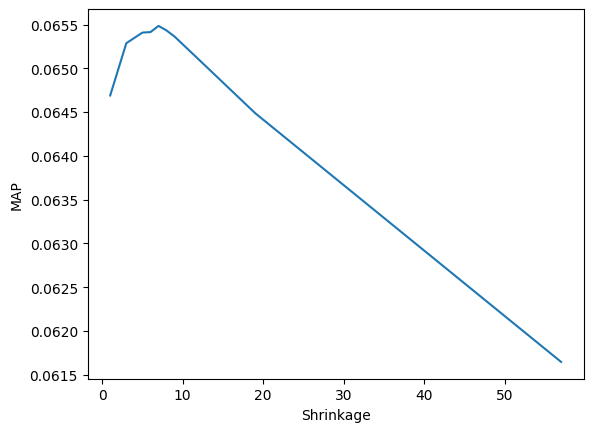

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [ ]:
best_shrink = hyperparameter_search_rnd.loc[hyperparameter_search_rnd["MAP"].astype(float).idxmax()]
best_shrink

k               14
shrink           7
MAP       0.065484
Name: 8, dtype: object

Comparing different similarity heuristics

In [ ]:
similarity_heuristic_list = ["cosine", "dice", "jaccard", "pearson"]
hyperparameter_search_rnd = pd.DataFrame(columns = ["k", "shrink","similarity", "MAP"])
hyperparameter_search_rnd["similarity"] = similarity_heuristic_list
hyperparameter_search_rnd["k"] = best_k_value["k"]
hyperparameter_search_rnd["shrink"] = best_shrink["shrink"]

for index in hyperparameter_search_rnd.index:
    folds_map = []
    for k,fold in enumerate(data_folds):
      print(f'Fold {k} evaluations started')
      recommender = ItemKNNCFRecommender(fold['train'])
      recommender.fit(shrink=best_shrink["shrink"], topK=best_k_value["k"], similarity = hyperparameter_search_rnd.loc[index,"similarity"])

      map, mp,mr = evaluate_algorithm(fold['val'],recommender)
      folds_map.append(map)

    cv_map = np.array(folds_map).sum()/len(data_folds)
    print(f'The crossvalidation MAP for {hyperparameter_search_rnd.loc[index,"shrink"]} is {cv_map}')
    hyperparameter_search_rnd.loc[index,"MAP"] = cv_map

Fold 0 evaluations started
Similarity column 22348 (100.0%), 1588.97 column/sec. Elapsed time 14.06 sec
Recommender results are: Precision = 504.5000, Recall = 1216.8915, MAP = 0.0667
Fold 1 evaluations started
Similarity column 22348 (100.0%), 1583.34 column/sec. Elapsed time 14.11 sec
Recommender results are: Precision = 481.3000, Recall = 1183.9976, MAP = 0.0657
Fold 2 evaluations started
Similarity column 22348 (100.0%), 1618.14 column/sec. Elapsed time 13.81 sec
Recommender results are: Precision = 494.3000, Recall = 1211.5134, MAP = 0.0659
Fold 3 evaluations started
Similarity column 22348 (100.0%), 1610.63 column/sec. Elapsed time 13.88 sec
Recommender results are: Precision = 501.6000, Recall = 1206.4781, MAP = 0.0661
Fold 4 evaluations started
Similarity column 22348 (100.0%), 1617.72 column/sec. Elapsed time 13.81 sec
Recommender results are: Precision = 499.6000, Recall = 1186.7828, MAP = 0.0643
Fold 5 evaluations started
Similarity column 22348 (100.0%), 1623.90 column/sec.

    k  shrink similarity       MAP
0  14       7     cosine  0.065484
1  14       7       dice  0.065245
2  14       7    jaccard  0.065862
3  14       7    pearson  0.000056


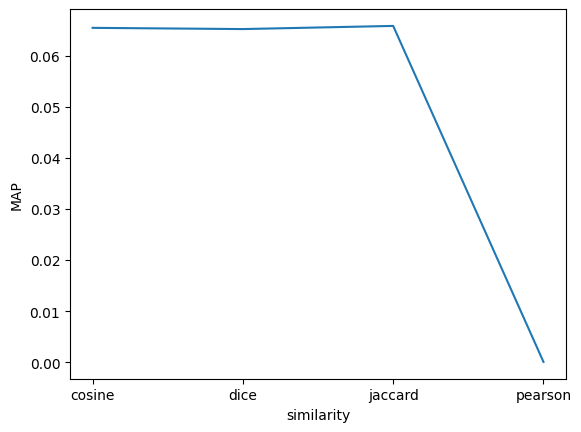

In [ ]:
print(hyperparameter_search_rnd)

pyplot.plot(hyperparameter_search_rnd["similarity"].values, hyperparameter_search_rnd["MAP"].values)
pyplot.ylabel('MAP')
pyplot.xlabel('similarity')
pyplot.show()

In [ ]:
urm_all = sps.csr_matrix((urm_all.data,
                            (urm_all.row, urm_all.col)))

In [ ]:
recommender = ItemKNNCFRecommender(urm_all)
recommender.fit(topK = 14,shrink=7)

Similarity column 22222 (100.0%), 1572.86 column/sec. Elapsed time 14.13 sec


**Save similarity matrix for this model**

In [ ]:
from scipy.sparse import save_npz

item_item_S = recommender.W_sparse
save_npz("/content/ItItSimilarity_noemptyprofiles_IBCF_kaggleMAP0.11585.npz", item_item_S)


# Predict for the test data

**Now let's read the data we want to predict for and see if there're overlaps with UserIDs in train data**

In [ ]:
urm_pred_path = '/content/data_target_users_test.csv'

urm_pred_df = pd.read_csv(filepath_or_buffer=urm_pred_path,
                                sep=",",
                                header=0,
                                dtype={0:int},
                                engine='python')

urm_pred_df.columns = ["UserID"]
len(urm_pred_df['UserID'])
print('Unique user id to predict:', urm_pred_df['UserID'].nunique())

Unique user id to predict: 10882


**Now we make the predictions for every user in our test set and add them to pred_df**

Here we list the users that are in our test set but not in our whole train set

In [ ]:
users_not_in_train = urm_pred_df[~urm_pred_df['UserID'].isin(urm_all_df['UserID'])]

print("Users in urm_pred_df but not in urm_all_orgdf:")
print(users_not_in_train)
print(len(users_not_in_train))

users_not_in_train = users_not_in_train['UserID'].to_numpy()

Users in urm_pred_df but not in urm_all_orgdf:
       UserID
54         60
58         65
147       168
223       261
272       316
...       ...
10682   12775
10699   12798
10729   12837
10802   12921
10856   12992

[221 rows x 1 columns]
221


In [ ]:
usr_id_notintrain = 60
recommendations = recommender.recommend(usr_id_notintrain, at=10, users_not_in_train=users_not_in_train)
print(recommendations)

['517 189 44 0 284 808 285 1 557 1266']


**Do the predictions, but bear in mind that before feeding the user_id to the model you need to translate it to the model user indices space. Also, you have to translate the recommended item IDs into the original IDs space form the model item IDs space**

In [ ]:
pred_df = pd.DataFrame(columns = ['user_id','item_list'])

for userid in urm_pred_df['UserID']:
  if userid in user_original_ID_to_index.keys():
    # Map user ID to the index of model user space
    usr_idx = user_original_ID_to_index[userid]
    recomendatoins = recommender.recommend(usr_idx, at=10,exclude_seen = True, users_not_in_train=users_not_in_train)
    # Map item indices from model item space to original item ID
    recomendatoins = [item_index_to_original_ID[idx] for idx in recomendatoins]
  else:
    # If the user isn't present in the given data, recommend TopPop items
    recomendatoins = ["517 189 44 0 284 808 285 1 557 1266"]

  recomendatoins = " ".join(str(item) for item in recomendatoins)
  pred_df.loc[len(pred_df)] = [userid,recomendatoins]

In [ ]:
pred_df

,user_id,item_list
0,1,101 36 403 515 506 977 1546 869 922 1338
1,2,1095 47 11 28 50 12 5 136 1522 277
2,3,59 956 584 536 259 857 648 1281 2748 414
3,4,28 50 249 145 136 277 5 639 679 1146
4,5,1570 77 5138 116 148 7033 175 9039 10150 170
...,...,...
10877,13020,6450 6198 7395 6452 6749 7394 4323 15943 161 403
10878,13021,6179 7027 6451 6426 7395 6720 6749 17942 13621...
10879,13022,1668 1446 1411 1674 809 10789 21627 8550 8100 ...
10880,13023,706 639 1124 1146 1534 1273 928 1535 1107 1290


In [ ]:
pred_df.to_csv('/content/predIBCFwithCV_Max.csv',index=False)